# Домашнее задание 2. Keras.

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt

(train_images,train_labels), (test_images,test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


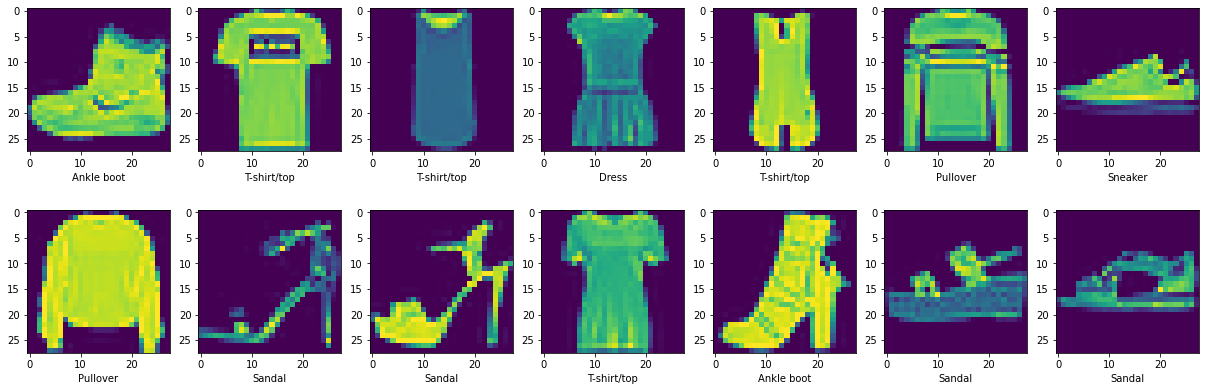

In [2]:
target_names = {0: 'T-shirt/top',
                1: 'Trouser',
                2: 'Pullover',
                3: 'Dress',
                4: 'Coat',
                5: 'Sandal',
                6: 'Shirt',
                7: 'Sneaker',
                8: 'Bag',
                9: 'Ankle boot'}

N = 14
rows = 1 if N <= 7 else N // 7 + 1
cols = N if N <= 7 else 7

plt.figure(figsize=(3*cols, 3.5*rows))
for i in range(N):
    plt.subplot(rows, cols, i+1)
    plt.imshow(train_images[i, :, :])
    plt.xlabel(f'{target_names[train_labels[i]]}')
plt.show()

In [3]:
# Normalize the images.
train_images = (train_images / 127.5) - 1
test_images = (test_images / 127.5) - 1

# Flatten the images.
X_train = train_images.reshape((-1, 784))
X_test = test_images.reshape((-1, 784))

In [4]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [5]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

Таргет идеально сбалансирован.

Напишем функцию, строящую полносвязную многослойную нейронную сеть с заданными параметрами: количеством слоев, количеством нейронов в слоях, функциями активации каждого слоя, оптимизатором, функцией потерь и подсчитываемыми метриками.

In [6]:
def build_nn(n_layers, n_neurons, activation,
             optimizer, loss, metrics,
             name_to_save_weights=None, name_to_load_weights=None):
    model = Sequential([Dense(n_neurons[i], activation=activation[i]) if i != 0 else \
                        Dense(n_neurons[i], activation=activation[i], input_shape=(784,)) \
                        for i in range(n_layers)])
    
    if name_to_save_weights:
        model.save_weights(name_to_save_weights)
    
    if name_to_load_weights:
        model.load_weights(name_to_load_weights)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
    
    return model

In [7]:
# Создадим список для аккумулирования результатов качества сетей
results = []

Создадим, обучим 2хслойные нейросети с разным количеством нейронов в скрытом слое и построим графики по каждой сети с ходом обучения.

In [8]:
n_layers = 2
neuron_numbers = (100, 120, 150, 200, 300, 500)
activation = ('tanh', 'softmax')

optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ('accuracy')

epochs = 20
epochs_arr = np.arange(epochs + 1)
batch_size = 1024
val_split = 0.2
tr_num = int(X_train.shape[0] * (1 - val_split))

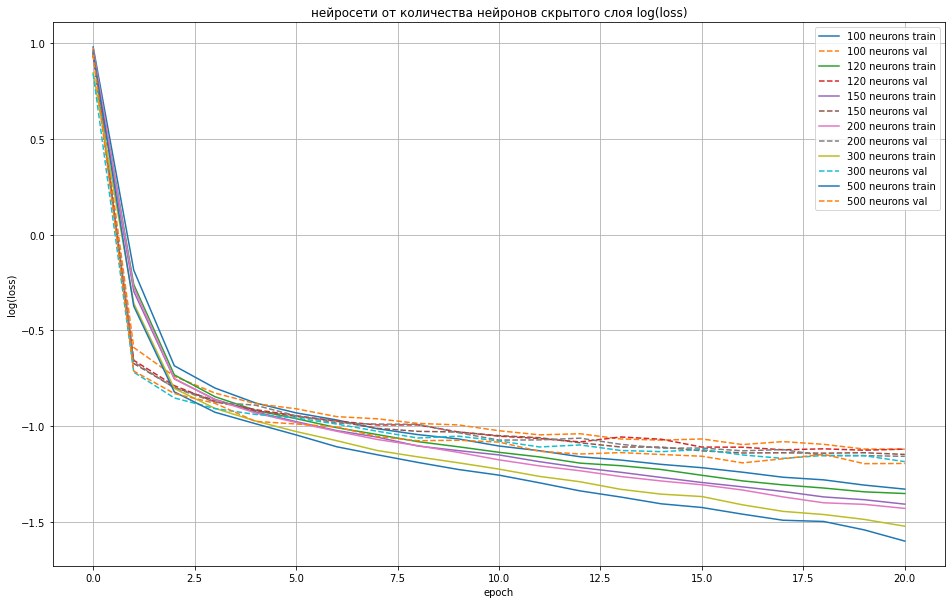

In [9]:
plt.figure(figsize=(16, 10))

for n_num in neuron_numbers:

    model = build_nn(n_layers, (n_num, 10), activation,
                     optimizer, loss, metrics)
        
    lh0_tr = model.evaluate(X_train[:tr_num, :], y_train[:tr_num], verbose=0)
    lh0_val = model.evaluate(X_train[tr_num:, :], y_train[tr_num:], verbose=0)

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'accuracy': lh.history['accuracy'][-1]})
    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'accuracy': lh.history['val_accuracy'][-1]})
    results.append({'model': f'2 layers {n_num} neurons',
                    'sample': 'test',
                    'loss': res_test[0],
                    'accuracy': res_test[1]})

    plt.plot(epochs_arr, np.log([lh0_tr[0]] + lh.history['loss']), '-', label=f'{n_num} neurons'+' train')
    plt.plot(epochs_arr, np.log([lh0_val[0]] + lh.history['val_loss']), '--', label=f'{n_num} neurons'+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от количества нейронов скрытого слоя log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

Как видим из зависимостей, на протяжении всего обучения значительное увеличение количества нейронов в слое не дает значительного уменьшения ошибки. К тому же после 20 эпох обучение уже вообще не давало прироста качества на валидации и сети начали переобучаться.

Построим и сравним сети, различающиеся разных количеством слоев с примерно равным каличеством настраиваемых параметров(400000).

In [10]:
layers_numbers = (2, 3, 5, 10)
neuron_numbers = [(500, 10),
                  (350, 340, 10),
                  (250, 240, 230, 220, 10),
                  (200, 180, 160, 150, 140, 130, 120, 110, 100, 10)]

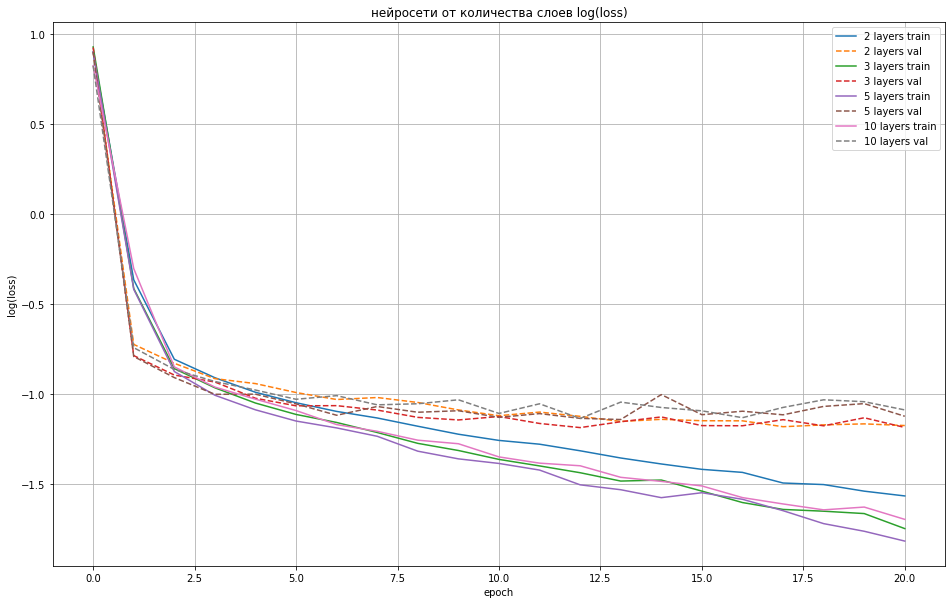

In [11]:
plt.figure(figsize=(16, 10))

for i in range(len(layers_numbers)):

    activation = (layers_numbers[i] - 1) * ['tanh'] + ['softmax']

    model = build_nn(layers_numbers[i], neuron_numbers[i], activation,
                     optimizer, loss, metrics)
        
    lh0_tr = model.evaluate(X_train[:tr_num, :], y_train[:tr_num], verbose=0)
    lh0_val = model.evaluate(X_train[tr_num:, :], y_train[tr_num:], verbose=0)

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'{layers_numbers[i]} layers 400000 parameters',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'accuracy': lh.history['accuracy'][-1]})
    results.append({'model': f'{layers_numbers[i]} layers 400000 parameters',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'accuracy': lh.history['val_accuracy'][-1]})
    results.append({'model': f'{layers_numbers[i]} layers 400000 parameters',
                    'sample': 'test',
                    'loss': res_test[0],
                    'accuracy': res_test[1]})

    plt.plot(epochs_arr, np.log([lh0_tr[0]] + lh.history['loss']), '-', label=f'{layers_numbers[i]} layers'+' train')
    plt.plot(epochs_arr, np.log([lh0_val[0]] + lh.history['val_loss']), '--', label=f'{layers_numbers[i]} layers'+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от количества слоев log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

Все не так однозначно, но в целом к 10ой эпохе сети с меньшим количеством слоев (2, 3) показывают лучшие результаты. Сети большим количеством слоев быстрее переобучаются и не особо выделяются хорошими показателями качества.

Посмотрим теперь на результаты при работе разных оптимизаторов.

In [12]:
layers_numbers = 3
neuron_numbers = (350, 340, 10)
activation = ('tanh', 'tanh', 'softmax')

optimizers = ['SGD','RMSProp','adam','NAdam']
loss = 'categorical_crossentropy'
metrics = ('accuracy')

epochs = 20
epochs_arr = np.arange(epochs + 1)
batch_size = 1024
val_split = 0.2
tr_num = int(X_train.shape[0] * (1 - val_split))

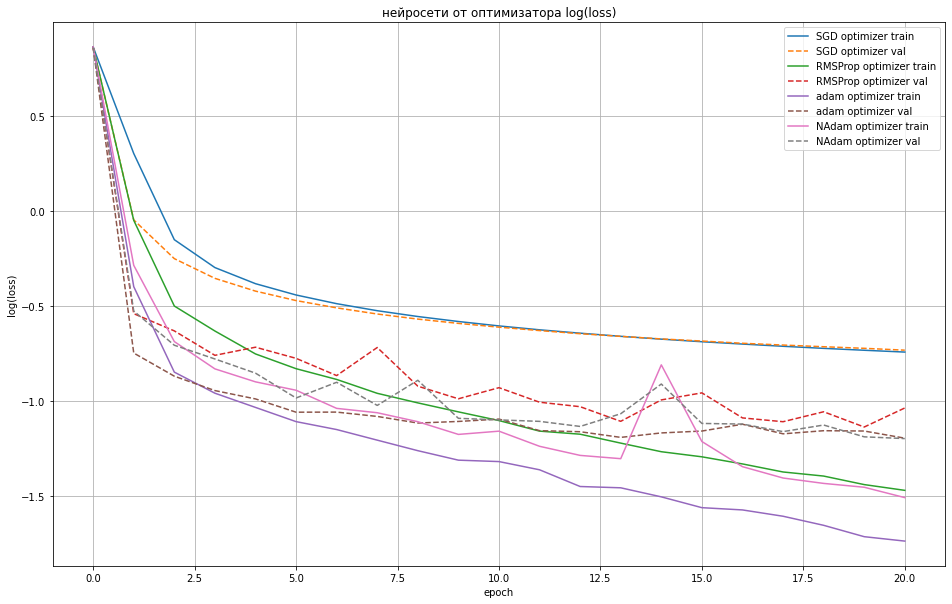

In [13]:
plt.figure(figsize=(16, 10))

for i in range(len(optimizers)):

    if i != 0:
        model = build_nn(layers_numbers, neuron_numbers, activation,
                         optimizers[i], loss, metrics,
                         name_to_load_weights='model_weights.h5')
    else:
        model = build_nn(layers_numbers, neuron_numbers, activation,
                         optimizers[i], loss, metrics,
                         name_to_save_weights='model_weights.h5')
        
    lh0_tr = model.evaluate(X_train[:tr_num, :], y_train[:tr_num], verbose=0)
    lh0_val = model.evaluate(X_train[tr_num:, :], y_train[tr_num:], verbose=0)

    lh = model.fit(X_train,
                   y_train,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_split=val_split,
                   verbose=0)
    
    res_test = model.evaluate(X_test, y_test, verbose=0)

    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'train',
                    'loss': lh.history['loss'][-1],
                    'accuracy': lh.history['accuracy'][-1]})
    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'validate',
                    'loss': lh.history['val_loss'][-1],
                    'accuracy': lh.history['val_accuracy'][-1]})
    results.append({'model': f'{optimizers[i]} optimizer',
                    'sample': 'test',
                    'loss': res_test[0],
                    'accuracy': res_test[1]})

    plt.plot(epochs_arr, np.log([lh0_tr[0]] + lh.history['loss']), '-', label=f'{optimizers[i]} optimizer'+' train')
    plt.plot(epochs_arr, np.log([lh0_val[0]] + lh.history['val_loss']), '--', label=f'{optimizers[i]} optimizer'+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.show()

Вкупе относительно стабильности обучения и сопротивления к переобучения лучше всего себя ведет сеть с оптимизатором Nadam.

In [14]:
df = pd.DataFrame(results)
df = df.set_index(['model'])

In [15]:
df[df['sample'] == 'test'].sort_values(by='loss', ascending=True)

,sample,loss,accuracy
model,,,
2 layers 500 neurons,test,0.326218,0.8819
3 layers 400000 parameters,test,0.328692,0.8878
NAdam optimizer,test,0.329777,0.8820
2 layers 300 neurons,test,0.332214,0.8825
adam optimizer,test,0.332988,0.8863
2 layers 400000 parameters,test,0.337205,0.8799
2 layers 200 neurons,test,0.338576,0.8781
2 layers 150 neurons,test,0.348876,0.8777
2 layers 100 neurons,test,0.349602,0.8739


По итогу лучшей моделью будет сеть с 3мя слоями, 350/340/10 нейронами в каждом слое соответственно и оптимизатором Nadam. Посчитаем на этой модели Precision, Recall, F1 для каждого класса.

In [16]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)

313/313 [==============================] - 1s 3ms/step


In [17]:
def class_precision(real, pred, t_class):
    pred_positives = real[preds == t_class]
    return (pred_positives == t_class).sum() / pred_positives.shape[0]

def class_recall(real, pred, t_class):
    real_classes = preds[real == t_class]
    return (real_classes == t_class).sum() / real_classes.shape[0]

def f1_measure(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [18]:
for c_num, c_name in target_names.items():
    prec = np.round(class_precision(test_labels, preds, c_num), 3)
    rec = np.round(class_recall(test_labels, preds, c_num), 3)
    f1 = np.round(f1_measure(prec, rec), 3)
    print(f'class "{c_num}" ({c_name}): precision={prec}, recall={rec}, f1={f1}')

class "0" (T-shirt/top): precision=0.873, recall=0.793, f1=0.831
class "1" (Trouser): precision=0.986, recall=0.969, f1=0.977
class "2" (Pullover): precision=0.765, recall=0.848, f1=0.804
class "3" (Dress): precision=0.842, recall=0.918, f1=0.878
class "4" (Coat): precision=0.838, recall=0.775, f1=0.805
class "5" (Sandal): precision=0.961, recall=0.949, f1=0.955
class "6" (Shirt): precision=0.722, recall=0.695, f1=0.708
class "7" (Sneaker): precision=0.928, recall=0.95, f1=0.939
class "8" (Bag): precision=0.954, recall=0.974, f1=0.964
class "9" (Ankle boot): precision=0.96, recall=0.949, f1=0.954


Увереннее всего модель определяла классы "Trouser", "Bag", "Ankle boot" (брюки, сумки, ботинки). Да и собственно с остальной обувью в целом неплохо справилась. Больше всего проблем возникало при классификации "Shirt", "Pullover", "Coat", что и логично - по картинкам данного качества сложно отличить друг от друга рубашку, пуловер и пальто.